In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, brier_score_loss, log_loss, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from imblearn.under_sampling import NearMiss
import os
sys.path.append(os.path.abspath("../src"))

from features import preprocess_telco_data

In [2]:
# Load dataset
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = preprocess_telco_data(df)

# Store model results for comparison
model_results = []


LogisticRegression Results
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC AUC: 0.8319752964989567
Brier Score: 0.14061982601446726
Accuracy: 0.7903340440653873
F1 Score: 0.566813509544787


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

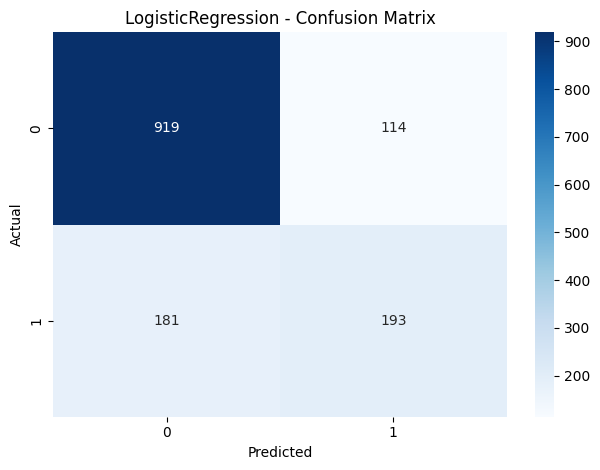


RandomForest Results
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1033
           1       0.68      0.48      0.56       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC: 0.8322884905084097
Brier Score: 0.1397147758470018
Accuracy: 0.8009950248756219
F1 Score: 0.559748427672956


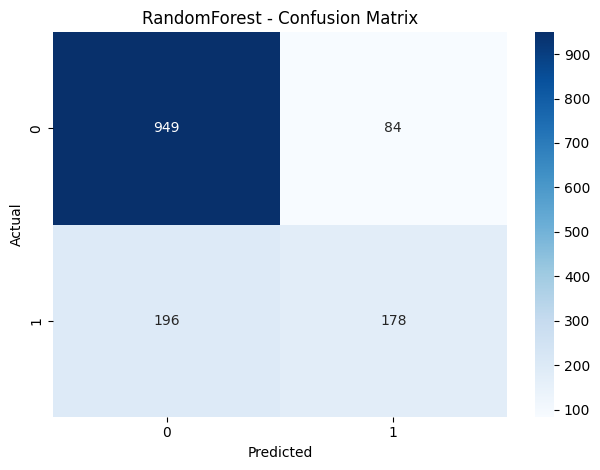

In [3]:
# Split features and target
X = df.drop(columns='Churn')
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train improved models
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, C=0.5, penalty='l2'),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, y_proba)
    brier = brier_score_loss(y_test, y_proba)
    logloss = log_loss(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Results")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc)
    print("Brier Score:", brier)
    print("Accuracy:", acc)
    print("F1 Score:", f1)

    model_results.append({
        "Model": name,
        "ROC AUC": roc,
        "Brier Score": brier,
        "Log Loss": logloss,
        "Accuracy": acc,
        "F1 Score": f1
    })

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/{name}_confusion_matrix.png')
    plt.show()

15:31:50 - cmdstanpy - INFO - CmdStan start processing



Fitting Bayesian Logistic Regression with CmdStanPy...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:32:42 - cmdstanpy - INFO - CmdStan done processing.



             alpha      beta[1]      beta[2]      beta[3]      beta[4]  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -1.742444     0.095714    -1.447560    -0.627820     0.690129   
std       0.060725     0.034937     0.166828     0.683025     0.174406   
min      -1.989100    -0.023330    -2.113190    -3.169240     0.096848   
25%      -1.783975     0.072863    -1.559077    -1.089730     0.568489   
50%      -1.740315     0.095515    -1.445355    -0.638167     0.684978   
75%      -1.698730     0.118950    -1.334245    -0.160408     0.812238   
max      -1.553860     0.218155    -0.922481     2.046890     1.320160   

           beta[5]      beta[6]      beta[7]      beta[8]      beta[9]  ...  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000  ...   
mean     -0.015694     0.024829    -0.099679    -0.020365     0.040609  ...   
std       0.035990     0.043516     0.046172     0.695646     0.693685  ...   
min      -0.1518

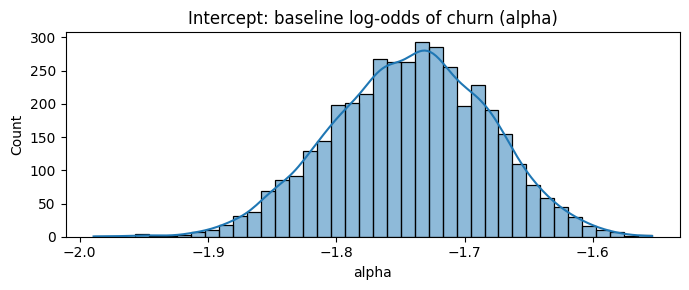

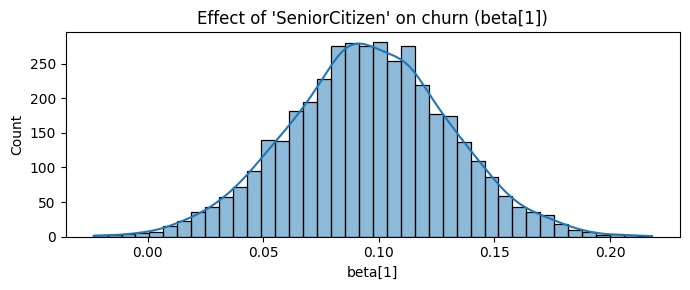

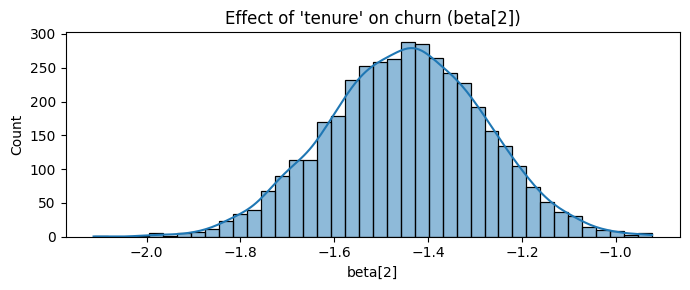

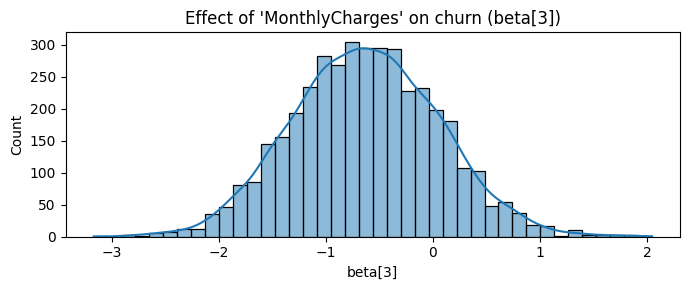

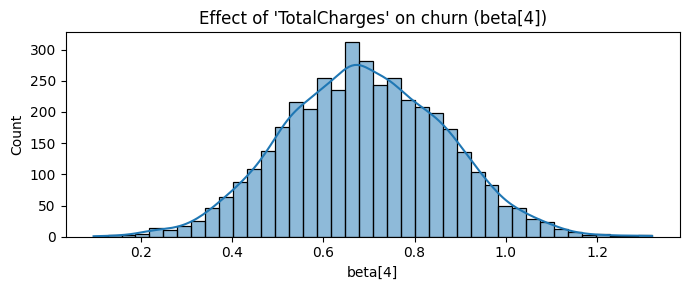

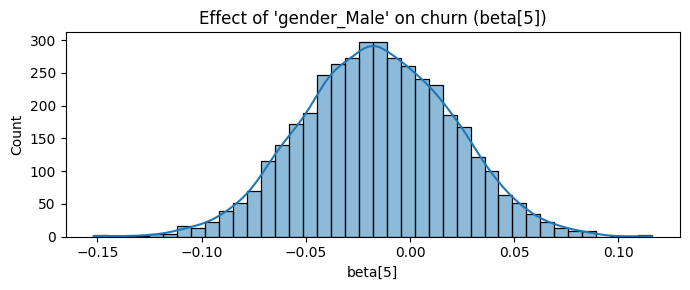

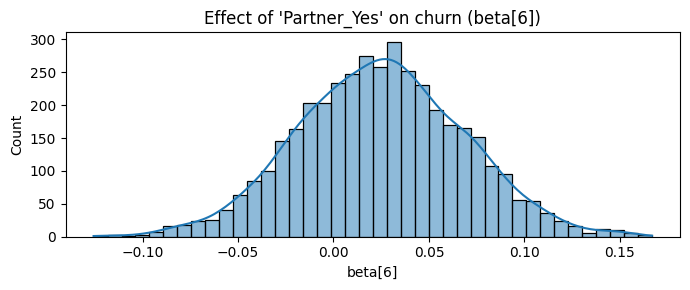

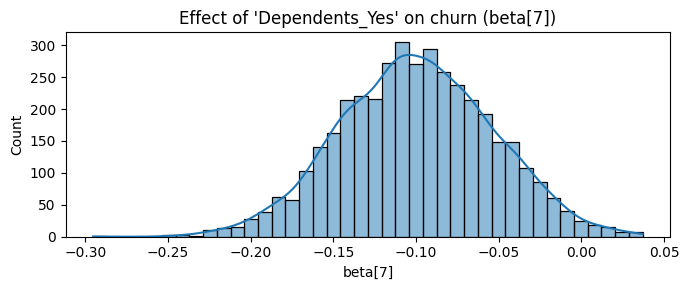

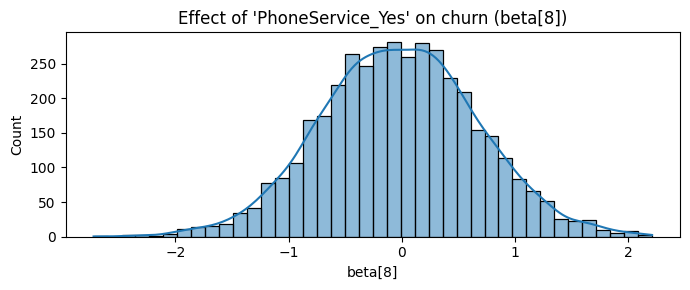

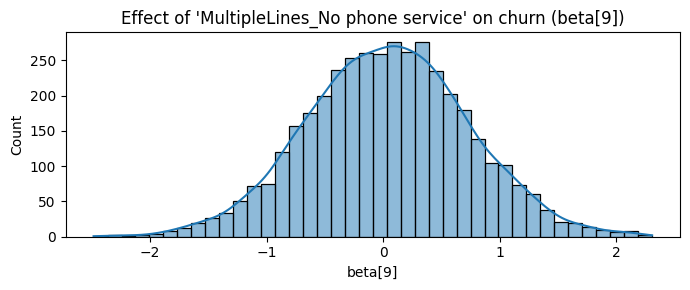

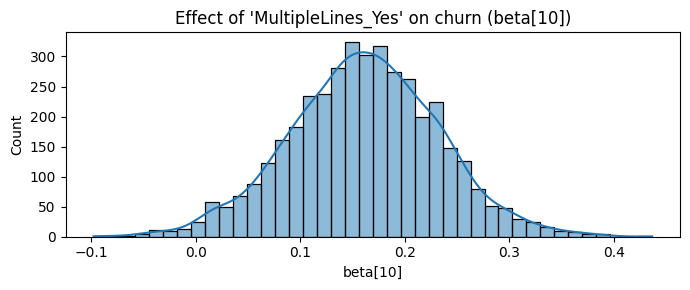

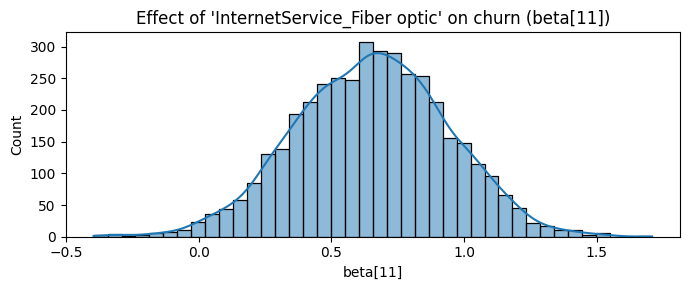

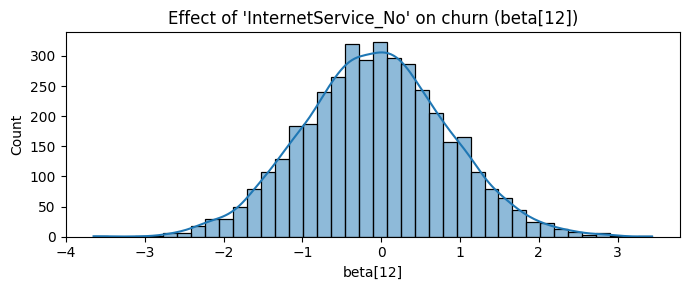

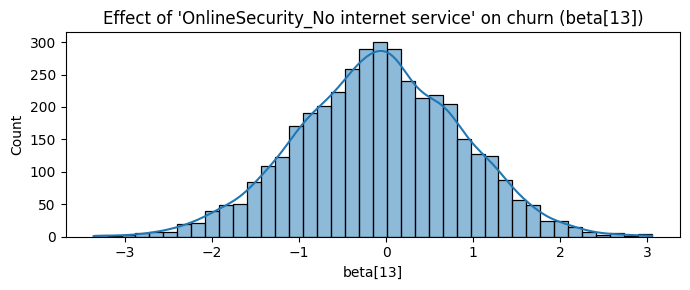

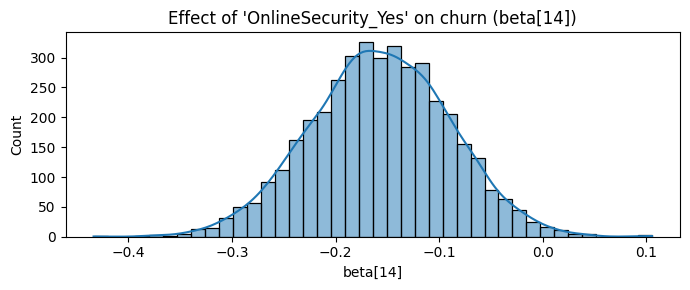

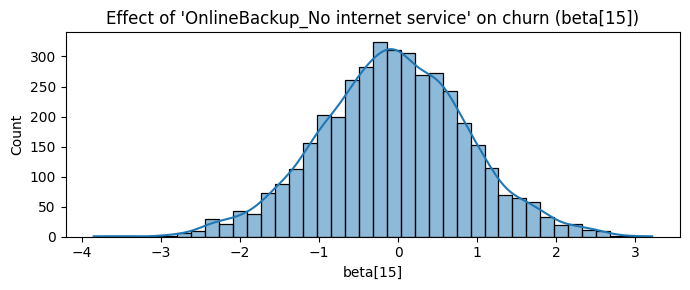

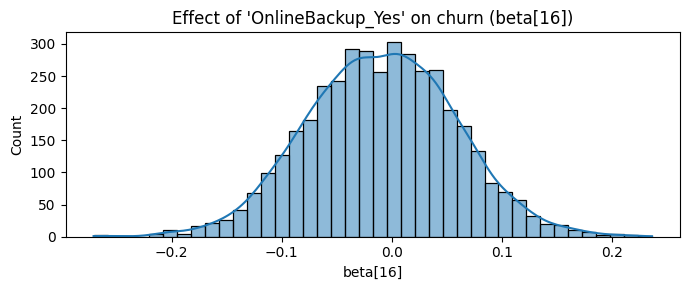

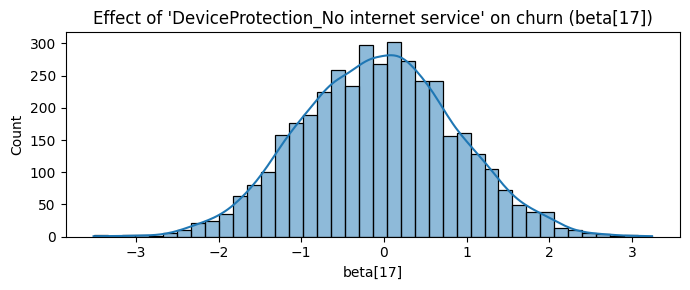

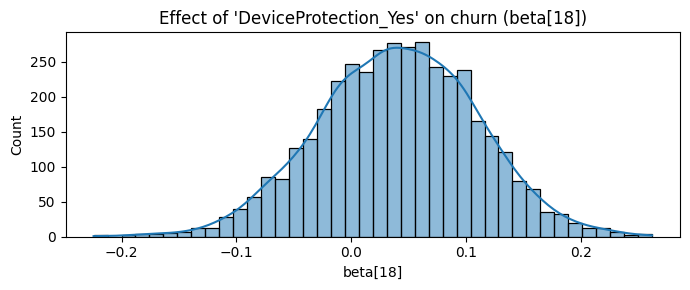

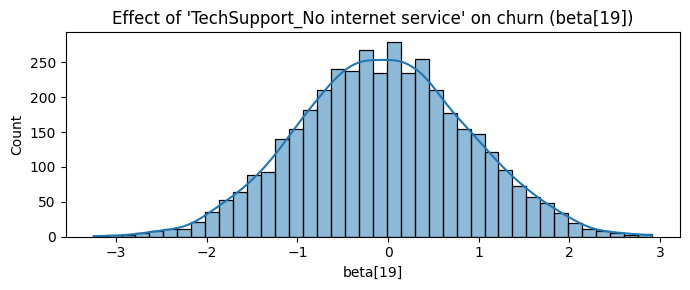

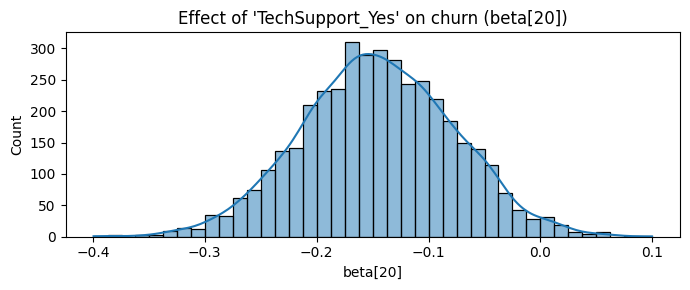

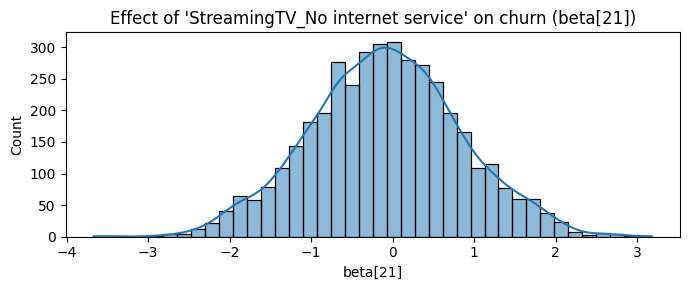

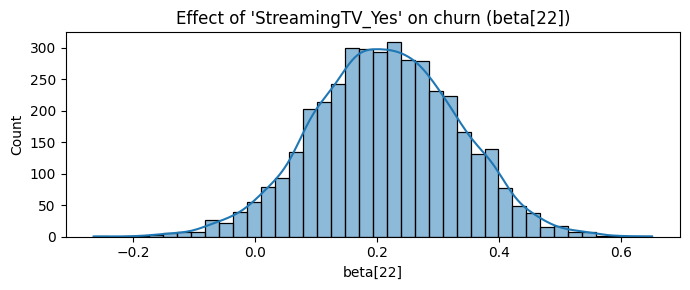

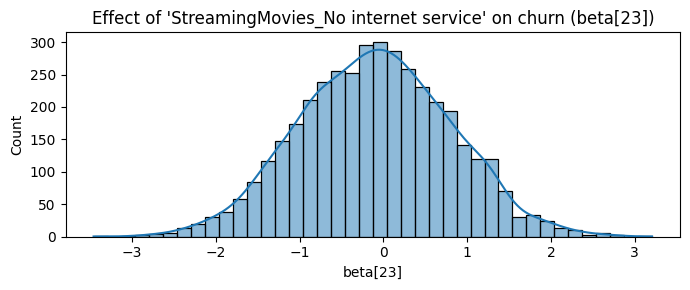

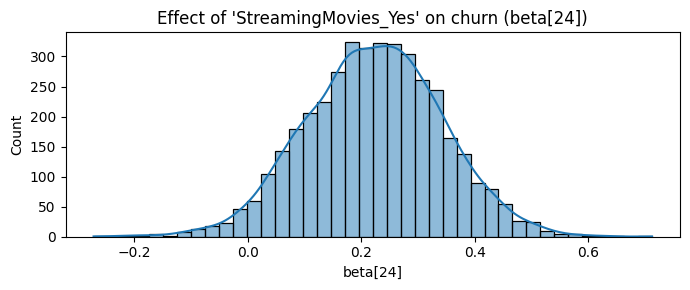

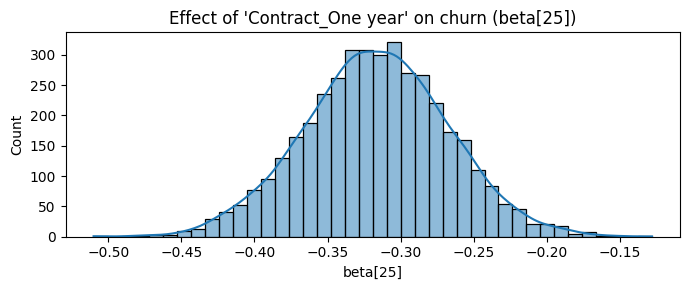

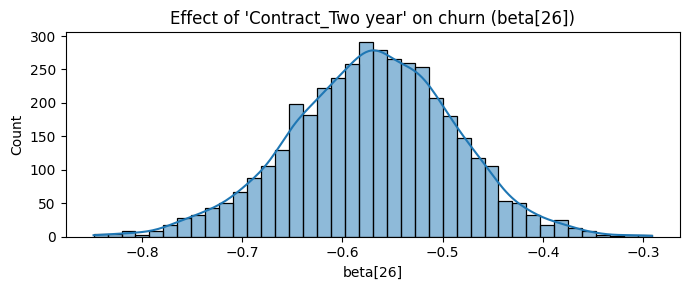

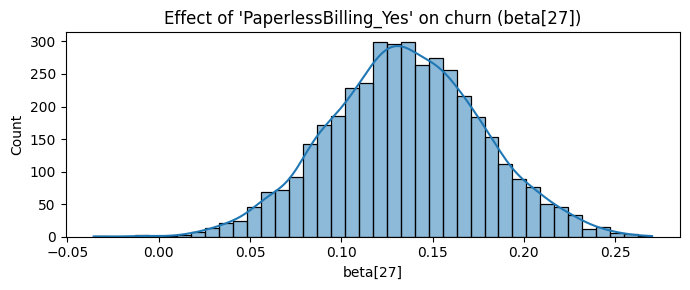

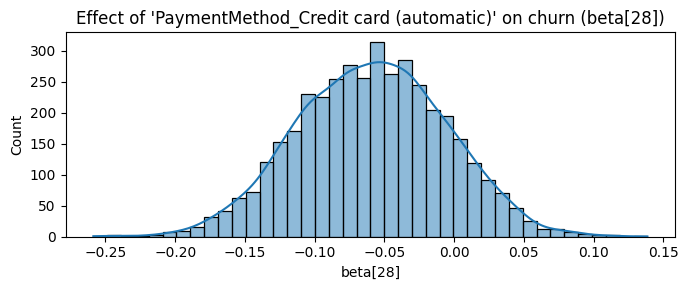

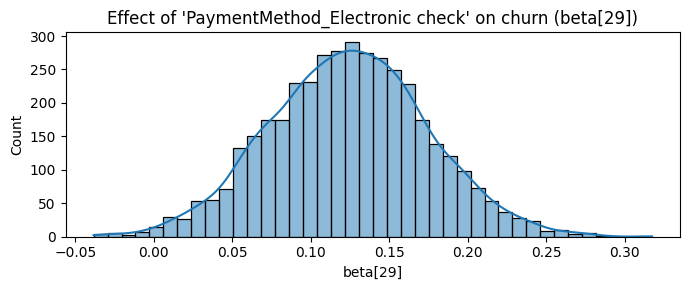

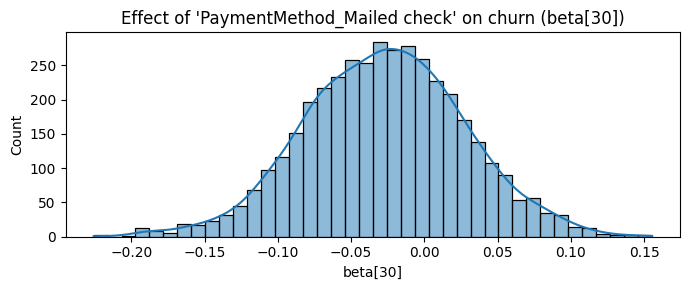

In [4]:
# Bayesian Logistic Regression using CmdStanPy
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler

print("\nFitting Bayesian Logistic Regression with CmdStanPy...")

# Normalize all features for Bayesian model
scaler = StandardScaler()
X_bayes = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
y_bayes = y_train.astype(int)

stan_data = {
    "N": len(X_bayes),
    "K": X_bayes.shape[1],
    "X": X_bayes.values,
    "y": y_bayes.values
}

# Save model to temporary file
stan_model_path = "../models/logistic_model.stan"

# Compile and fit
model = CmdStanModel(stan_file=stan_model_path)
fit = model.sample(data=stan_data, chains=4, parallel_chains=4, iter_sampling=1000, iter_warmup=500, seed=42)

posterior_df = fit.draws_pd()
print(posterior_df[["alpha"] + [f"beta[{i}]" for i in range(1, X_bayes.shape[1]+1)]].describe())

# Evaluate Bayesian predictions using posterior mean
y_pred_proba_bayes = posterior_df.filter(like="y_pred").mean().values
y_pred_bayes = (y_pred_proba_bayes >= 0.5).astype(int)

bayes_roc_auc = roc_auc_score(y_bayes, y_pred_proba_bayes)
bayes_brier = brier_score_loss(y_bayes, y_pred_proba_bayes)
bayes_logloss = log_loss(y_bayes, y_pred_proba_bayes)
bayes_acc = accuracy_score(y_bayes, y_pred_bayes)
bayes_f1 = f1_score(y_bayes, y_pred_bayes)

print("\nBayesian Model Evaluation:")
print("ROC AUC:", bayes_roc_auc)
print("Brier Score:", bayes_brier)
print("Log Loss:", bayes_logloss)
print("Accuracy:", bayes_acc)
print("F1 Score:", bayes_f1)

model_results.append({
    "Model": "Bayesian Logistic Regression",
    "ROC AUC": bayes_roc_auc,
    "Brier Score": bayes_brier,
    "Log Loss": bayes_logloss,
    "Accuracy": bayes_acc,
    "F1 Score": bayes_f1
})

# Plot posteriors for all features
feature_names = X.columns.tolist()
descriptions = {f"beta[{i+1}]": f"Effect of '{feature_names[i]}' on churn" for i in range(len(feature_names))}
descriptions["alpha"] = "Intercept: baseline log-odds of churn"

for col in ['alpha'] + [f'beta[{i}]' for i in range(1, X_bayes.shape[1]+1)]:
    plt.figure(figsize=(7, 3))
    sns.histplot(posterior_df[col], kde=True, bins=40)
    plt.title(f'{descriptions.get(col, col)} ({col})')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/cmdstan_{col}_posterior.png')
    plt.show()


Model Comparison Summary:
                          Model   ROC AUC  Brier Score  Log Loss  Accuracy  \
2  Bayesian Logistic Regression  0.851621     0.132992  0.410399  0.808711   
1                  RandomForest  0.832288     0.139715  0.429302  0.800995   
0            LogisticRegression  0.831975     0.140620  0.431685  0.790334   

   F1 Score  
2  0.611552  
1  0.559748  
0  0.566814  


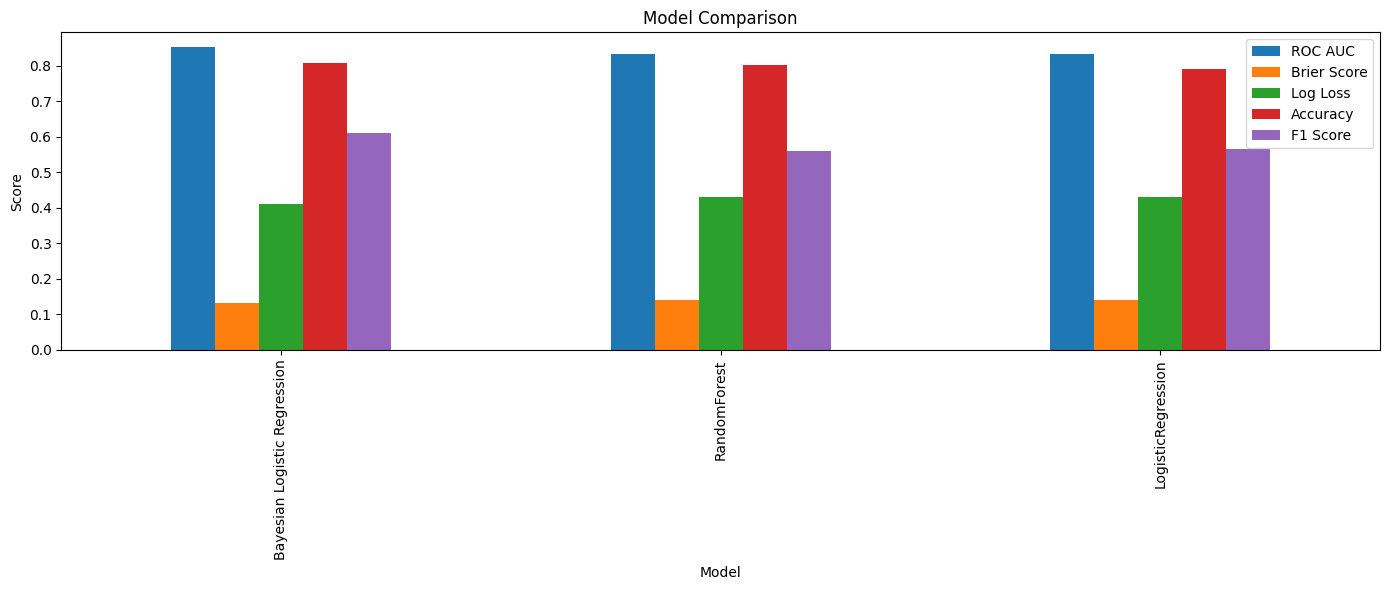

In [6]:
# Summary comparison plot
comparison_df = pd.DataFrame(model_results).sort_values(by="ROC AUC", ascending=False)
print("\nModel Comparison Summary:")
print(comparison_df)

comparison_df.set_index("Model")[["ROC AUC", "Brier Score", "Log Loss", "Accuracy", "F1 Score"]].plot(kind="bar", figsize=(14, 6), title="Model Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig("../reports/figures/model_comparison.png")
plt.show()
